In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras import backend
from utils import *

In [2]:

data = pd.read_csv('data.csv')

data['Change'].fillna(0, inplace=True)

data = expand_data(data)
# Select features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Change','upper_band','lower_band']
target = 'Close'

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[features])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length][-1]  # Predict the 'Change' value
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 3
X, y = create_sequences(scaled_data, seq_length)

# Split the data into training and testing sets
train_size = int(len(X) * 0.97)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM Model
model = Sequential()
model.add(LSTM(units=150, return_sequences=True, input_shape=(seq_length, len(features))))  # Adjust LSTM units
model.add(LSTM(units=150))  # Adjust LSTM units
model.add(Dense(1))

# Compile the model with a custom learning rate
learning_rate = 0.001  # Adjust learning rate here
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the Model
epochs = 150  # Adjust number of epochs here
batch_size = 10  # Adjust batch size here
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

# Step 5: Evaluate the Model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Step 6: Make Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate((np.zeros((predictions.shape[0], len(features) - 1)), predictions), axis=1))[:, -1]

# Inverse transform actual values for comparison
y_test_inverse = scaler.inverse_transform(np.concatenate((np.zeros((y_test.shape[0], len(features) - 1)), y_test.reshape(-1, 1)), axis=1))[:, -1]


Epoch 1/150

160/160 - 8s - loss: 0.0106 - 8s/epoch - 51ms/step
Epoch 2/150
160/160 - 1s - loss: 6.9713e-04 - 1s/epoch - 6ms/step
Epoch 3/150
160/160 - 1s - loss: 5.3970e-04 - 935ms/epoch - 6ms/step
Epoch 4/150
160/160 - 1s - loss: 3.0858e-04 - 1s/epoch - 6ms/step
Epoch 5/150
160/160 - 1s - loss: 2.3224e-04 - 1s/epoch - 6ms/step
Epoch 6/150
160/160 - 1s - loss: 2.3668e-04 - 951ms/epoch - 6ms/step
Epoch 7/150
160/160 - 1s - loss: 1.8912e-04 - 875ms/epoch - 5ms/step
Epoch 8/150
160/160 - 1s - loss: 1.8431e-04 - 969ms/epoch - 6ms/step
Epoch 9/150
160/160 - 1s - loss: 2.3046e-04 - 893ms/epoch - 6ms/step
Epoch 10/150
160/160 - 1s - loss: 2.3759e-04 - 953ms/epoch - 6ms/step
Epoch 11/150
160/160 - 1s - loss: 2.1692e-04 - 886ms/epoch - 6ms/step
Epoch 12/150
160/160 - 1s - loss: 2.2662e-04 - 962ms/epoch - 6ms/step
Epoch 13/150
160/160 - 1s - loss: 2.2884e-04 - 903ms/epoch - 6ms/step
Epoch 14/150
160/160 - 1s - loss: 2.4312e-04 - 857ms/epoch - 5ms/step
Epoch 15/150
160/160 - 1s - loss: 2.4807e-

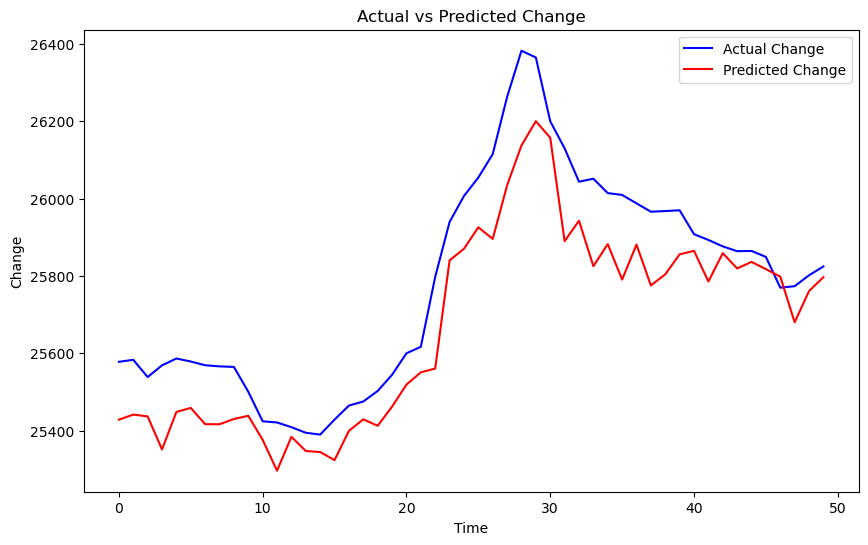

In [3]:
# Plot the predictions and actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse, color='blue', label='Actual Change')
plt.plot(predictions, color='red', label='Predicted Change')
plt.title('Actual vs Predicted Change')
plt.xlabel('Time')
plt.ylabel('Change')
plt.legend()
plt.show()

In [4]:
model.save('model/LSTM.h5')

C:\Users\MSI\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


mae = mean_absolute_error(y_test_inverse, predictions)
mse = mean_squared_error(y_test_inverse, predictions)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 113.02239067191768
Mean Squared Error (MSE): 17180.803683607042
Root Mean Squared Error (RMSE): 131.07556478461973
